In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import itertools
from tqdm import tqdm

# Project 1: **A Mixed graphical model sampler**: "random" generator of colombian high school students
## Advanced scientific computation
#### Physics Institute, University of Antioquia

## Parameters reading of the model

In [2]:
# Path to the JSON file
json_file_path = "parameters_mgm.json"

# Read JSON file
with open(json_file_path, "r") as json_file:
    theta = json.load(json_file)

## Methods

In [3]:
def alpha(s, xs):
    """
    Compute intercept of random variable X_s

    Parameters:
    s (int): Random variable index.
    xs (int or float): Realization of the random variable X_s.

    Returns:
    float: Intercept of random varibale X_s.
    """
    
    # The intercept is computed depending on whether X_s is categorial or Gaussian
    if isinstance(xs, int):
        alpha = theta["intercepts"][f"{s}"][xs-1]
    elif isinstance(xs, float):
        alpha = theta["intercepts"][f"{s}"][0]*xs
    
    return alpha

def interaction(s, t, xs, xt):
    """
    Compute interaction parameter between random variables X_s and X_t.

    Parameters:
    arg1 (int): Description of arg1.
    arg2 (str): Description of arg2.

    Returns:
    float: Interaction parameter between random variables X_s and X_t.
    """

    # The interaction parameter is computed depending on whether the interaction is between categorical variables or is between a Gaussian and a categorical variable
    if isinstance(xs, int) and isinstance(xt, int):
        alpha_int = theta["interactions"][f"{s}{t}"][xs-1][xt-1]
    elif isinstance(xs, int) and isinstance(xt, float):
        alpha_int = theta["interactions"][f"{s}{t}"][xs-1][0]*xt -0.5*xt**2
    else:
        print(f" Interaction {s}{t} is not supported.")
        alpha_int = np.nan
    
    return alpha_int

def p_theta(x):
    """
    Mixed graphical model for X = [X_1,..., X_m], where X_1,..., X_m-1 are categorical variables and X_m is normally distributed.

    Parameters:
    x ([int, int,..., float]): A certain realization of the random vector X = [X_1,..., X_m].
    
    Returns:
    float: Non-normalized joint probability of x = [x_1,..., x_m].
    """
    # This model only support one Gaussian variable in the last entry of X
    if not isinstance(x[-1], float):
        return print("The last entry of the random vector must be a float.")
    
    # All intercepts are computed
    intercepts = sum([alpha(s, x[s-1]) for s in np.arange(1, len(x)+1)])
    
    # All interactions are computed
    interactions = sum([interaction(s, t, x[s-1], x[t-1]) for s, t in list(itertools.combinations(np.arange(1, len(x)+1), 2))])
    
    # Mixed graphical model: exponential representation via maximun entropy
    p_theta = np.exp(intercepts + interactions)

    return p_theta

def mgm_sampler(n_obs, levels):
    """
    Generate a sample with n_obs observations according to the non-normalized joint probability density p_theta(X).

    Parameters:
    n_obs (int): Number of observations that will be generated.
    levels ([int, int,..., int]): List of number of categories of random variables X_1,... X_m. (levels[-1] = 1 because X_m is normally distributed.)

    Returns:
    [[int,..., int], [int,..., int],..., [float,..., float]]: List of m lists, one list per random variable. Each list has n_obs observations. 
    """

    # Number of variables of the mixed graphical model
    dim = len(levels)

    # List of sample lists, one list per random variable
    x = np.zeros((dim, n_obs))
    
    # Initialization of Metropolis algorithm
    x_prev = [np.random.randint(1, levels[i]+1) for i in range(dim-1)] + [np.random.normal(0, 1)]
    
    for i in range(n_obs):
        # Sample a new state candidate 
        x_star = [np.random.randint(1, levels[i]+1) for i in range(dim-1)] + [np.random.normal(0, 1)]

        u = np.random.uniform()
        # A is simple because our transition probability is symmetric (Metropolis only)
        A = p_theta(x=x_star)/p_theta(x=x_prev) # did we go up or down? 
    
        if u<A: # "coin flip" to see if we accept
            x_prev = x_star

        # filling each random variable sample list 
        for m in range(dim):
            x[m][i] = x_prev[m] 

    return x

def marginalDistributions(df, bins_list, sup_title = "Marginal distributions", bars_color="skyblue", show=True, savefig=False):
    """
    Make marginal distribution plots of each random variable and return the values of the histograms bins. 
    
    Parameters:
    df (pandas.Dataframe): dataframe with random variables as columns.
    bins_list (list): List of bins paramters of each subplot.
    sup_title (str): Superior title of the entire plot.
    bars_color (str): Histogram bars color.
    show (bool): Show figure or do not show it.
    savefig (bool): Save figure or do not save it.
    
    Returns:
    list: Lists of values of histogram bins.
    """
    
    # Number of random variables
    columns = df.columns
       
    # Create subplots
    fig, axs = plt.subplots(1, len(columns), figsize=(12, 4))

    # Values of the histogram bins
    val_hist_bins = []
    
    # Plot histograms on each subplot
    for i, column in enumerate(columns):
        n, bins, patches = axs[i].hist(df[column], 
                                       bins=bins_list[i], 
                                       density=True, 
                                       color=bars_color, 
                                       edgecolor='black', 
                                       linewidth=0.8, 
                                       label="$\mu={:.3f}$ \n $\sigma={:.3f}$".format(df[column].mean(), df[column].std()))
        axs[i].set_xlabel(f'{column}', fontsize=10)
        axs[i].legend()
        
        val_hist_bins.append(n)
        
    # Add a superior title above subplots
    plt.suptitle(sup_title, fontsize=16, fontweight='bold')

        # Adjust layout
    plt.tight_layout()

    if not show:
        plt.close()

    if savefig:
        plt.savefig(sup_title + ".png")
    
    return val_hist_bins
    

## **Results**: "random" generator of colombian high school students

In [4]:
# Generate a sample from mixed graphical model
n_obs = int(1e4)
mgm_sample = mgm_sampler(n_obs=n_obs, levels=[12, 2, 1])

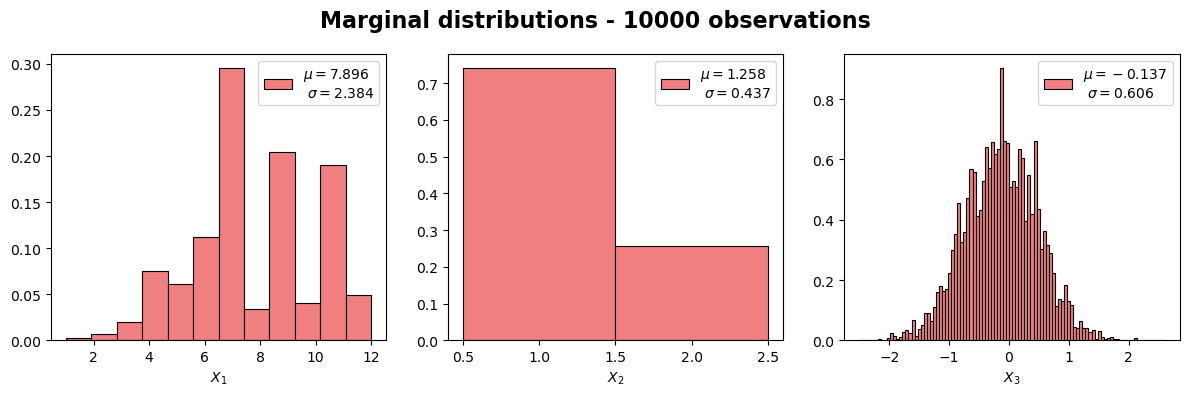

In [5]:
# Transpose the list of lists to swap rows and columns
data_transposed = list(map(list, zip(*mgm_sample)))
# Create a DataFrame
df = pd.DataFrame(data_transposed, columns=[f'$X_{i+1}$' for i in range(len(mgm_sample))])

sup_title = f"Marginal distributions - {n_obs} observations"
val_hist_bins_sample = marginalDistributions(df=df, 
                                             bins_list=[12, [0.5, 1.5, 2.5], 100], 
                                             sup_title=sup_title,
                                             bars_color="lightcoral", 
                                             savefig=True)

### Comparison of the marginal distributions of the generated sample and the marginal distributions of the real data

#### Real data

In [6]:
df_mgm = pd.read_csv("dataset_saber11_mgm_cca.csv")

In [7]:
# This dataset was used to train the mixed graphical model
df_mgm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405 entries, 0 to 8404
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fami_educacionmadre_num  8405 non-null   int64  
 1   cole_naturaleza_num      8405 non-null   int64  
 2   punt_global_scaled       8405 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 197.1 KB


#### Marginal distributions

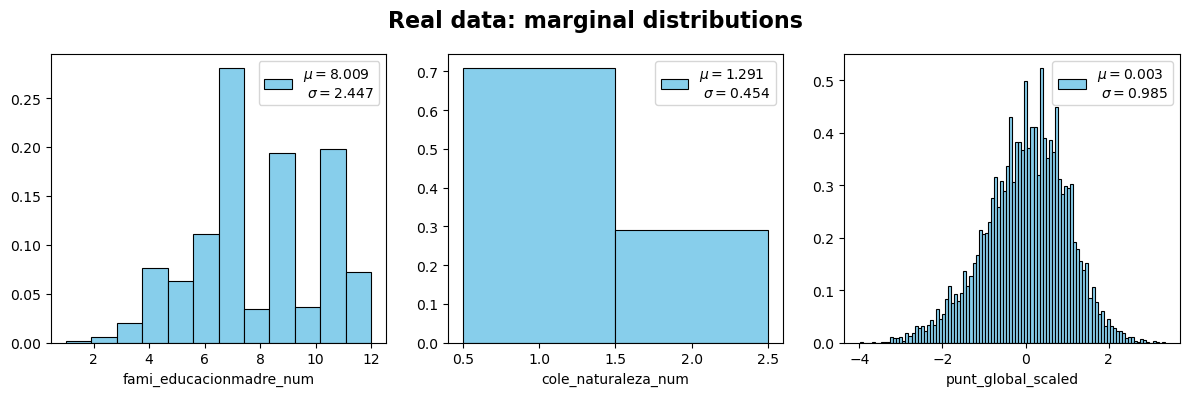

In [8]:
sup_title = "Real data: marginal distributions"
val_hist_bins_real = marginalDistributions(df=df_mgm, 
                                           bins_list=[12, [0.5, 1.5, 2.5], 100], 
                                           sup_title=sup_title, 
                                           savefig=True)

#### Metric for model validation: RMSE

In [ ]:
rmse_dist = []

n_samples = int(1e2)
n_obs = int(1e4)
for sample in tqdm(range(n_samples)):

    # Generate a sample
    mgm_sample = mgm_sampler(n_obs=n_obs, levels=[12, 2, 1])
    
    # Transpose the list of lists to swap rows and columns
    data_transposed = list(map(list, zip(*mgm_sample)))
    # Create a DataFrame
    df = pd.DataFrame(data_transposed, columns=[f'$X_{i+1}$' for i in range(len(mgm_sample))])

    # Values of histogram bins for the current sample
    val_hist_bins_sample = marginalDistributions(df=df, bins_list=[12, [0.5, 1.5, 2.5], 100], show=False)

    # RMSE of marginal distributions per sample
    rmse_sample = []
    for i in range(len(val_hist_bins_real)):
        # Calculate the mean squared error (MSE)
        mse = np.mean((val_hist_bins_real[i] - val_hist_bins_sample[i])**2)
        
        # Calculate the root mean squared error (RMSE)
        rmse = np.sqrt(mse)
    
        rmse_sample.append(rmse)

    rmse_dist.append(rmse_sample)

  7%|▋         | 7/100 [00:04<01:03,  1.46it/s]

In [ ]:
# Create a DataFrame
df = pd.DataFrame(rmse_dist, columns=[f'RMSE for $X_{i+1}$' for i in range(len(mgm_sample))])

sup_title = f"Distributions of RMSE for {n_samples} samples"
val_hist_bins_sample = marginalDistributions(df=df,
                                             bins_list=[10, 10 , 10],
                                             sup_title=sup_title,
                                             bars_color='mediumaquamarine', 
                                             savefig=True)